# ASR Dataset Quality Evaluation

Manual quality check of 100 randomly sampled transcriptions from the [dataset](https://huggingface.co/datasets/islomov/news_youtube_uzbek_speech_dataset). 
Evaluated Word Error Rate (WER), Character Error Rate (CER), and foreign language contamination.

**Methodology:**
1. Randomly sampled 100 audio files from the dataset
2. Extracted audio from parquet files using sample IDs
3. Manually verified and corrected transcriptions using custom HTML checker tool
4. Computed WER/CER metrics and foreign words count

In [18]:
import io
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import gc  # Garbage collector
from tqdm import tqdm  # Progress bar library

DATASET_DIR = "./datasets/news_youtube_uzbek_speech_dataset/data"
output_csv_path = os.path.join(DATASET_DIR, "dataset.csv")

### Create csv file with all data and computed statistics

In [ ]:
def normalize_uzbek_apostrophes(text):
    """Normalize all apostrophe variants to straight apostrophe"""
    apostrophe_variants = [
        "‘",  # U+2018 (left single quotation mark) - common in Uzbek
        "’",  # U+2019 (right single quotation mark) - common in Uzbek
        "ʼ",  # U+02BC (modifier letter apostrophe)
        "ʻ",  # U+02BB (modifier letter turned comma)
        "ʽ",  # U+02BD (modifier letter reversed comma)
        "`",  # U+0060 (grave accent)
        "ˊ",  # U+02CA (modifier letter acute accent)
        "ˋ",  # U+02CB (modifier letter grave accent)
    ]

    for variant in apostrophe_variants:
        text = text.replace(variant, "'")

    return text

def compute_statistics(df: pd.DataFrame, ignore_sampling_rate=True) -> dict:
    """Extract statistics without keeping audio in memory"""
    stats = {
        "id": [],
        "text": [],
        "audio_path": [],
        "duration": [],
        "char_count": [],
        "word_count": [],
    }
    if not ignore_sampling_rate:
        stats["sampling_rate"] = []

    for i in range(len(df)):
        # Extract metadata
        stats["id"].append(df.iloc[i]["id"])
        # Remove new lines if it exists
        text = df.iloc[i]["text"].replace("\n", " ")
        stats["text"].append(normalize_uzbek_apostrophes(text))
        stats["audio_path"].append(df.iloc[i]["audio"]["path"])

        # Decode audio
        audio_bytes = df.iloc[i]["audio"]["bytes"]
        audio_array, sr = sf.read(io.BytesIO(audio_bytes))

        duration = len(audio_array) / sr
        stats["duration"].append(duration)
        stats["char_count"].append(len(text))
        stats["word_count"].append(len(text.split()))
        if not ignore_sampling_rate:
            stats["sampling_rate"].append(sr)

        # Clear audio from memory immediately
        del audio_bytes, audio_array

    return stats


parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

all_data = []
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    df_partial = pd.read_parquet(parquet_file_path)

    stats = compute_statistics(df_partial)
    all_data.append(pd.DataFrame(stats))

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

# Combine all data
df = pd.concat(all_data, ignore_index=True)
del all_data  # Free memory
gc.collect()

df["id"] = df["id"].astype(int)
df.set_index("id", inplace=True)
df.to_csv(output_csv_path)

Found 34 parquet files. Started processing...



Processing files: 100%|██████████| 34/34 [00:50<00:00,  1.48s/it]


In [21]:
df = pd.read_csv(output_csv_path, index_col="id")

print(df.info())
print(df.describe())
print("\nFirst few rows:")
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 20795 entries, 4285 to 19573
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   text        20795 non-null  object 
 1   audio_path  20795 non-null  object 
 2   duration    20795 non-null  float64
 3   char_count  20795 non-null  int64  
 4   word_count  20795 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 974.8+ KB
None
           duration    char_count    word_count
count  20795.000000  20795.000000  20795.000000
mean      25.872685    358.585814     45.937725
std        5.792185    117.732594     15.300639
min        3.013500      8.000000      1.000000
25%       23.877375    291.000000     37.000000
50%       28.709375    378.000000     48.000000
75%       30.000000    443.000000     56.000000
max       30.000062    690.000000     97.000000

First few rows:


,text,audio_path,duration,char_count,word_count
id,,,,,
4285,Chiqqandan keyingi rejalarni o'ylab qolganmisi...,00004285.wav,28.518875,425,57
4286,Qoʻchqor Oʻlmas Ismoilovichga Oʻzbekiston Resp...,00004286.wav,25.904000,351,38
4287,Mulki Zulfiya Zayniddinovna nomiga rasmiylasht...,00004287.wav,15.152000,169,19
4288,Oxunov mahalla fuqarolar yig'ini hududida joyl...,00004288.wav,29.509375,331,41
4289,128 million 177 ming 500 soʻm pul hamda 2016-y...,00004289.wav,27.152000,188,28


### Dataset statistics plotted

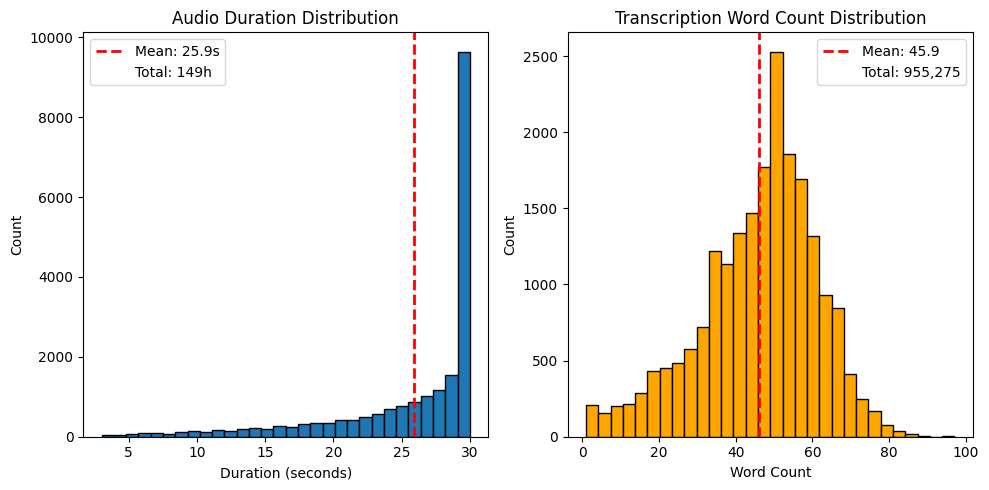

In [22]:
def plot_distribution_graphs(df: pd.DataFrame):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    total_duration = df["duration"].sum()
    total_duration_label = (
        f"Total: {total_duration / 3600:,.0f}h"
        if total_duration / 3600 >= 1
        else f"Total: {total_duration / 60:,.0f}min"
    )

    axes[0].hist(df["duration"], bins=30, edgecolor="black")
    axes[0].axvline(
        df["duration"].mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f'Mean: {df["duration"].mean():.1f}s',
    )
    axes[0].axvline(
        25,
        color="blue",
        linestyle="",
        linewidth=2,
        label=total_duration_label,
    )
    axes[0].set_xlabel("Duration (seconds)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Audio Duration Distribution")
    axes[0].legend()

    axes[1].hist(df["word_count"], bins=30, edgecolor="black", color="orange")
    axes[1].axvline(
        df["word_count"].mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f'Mean: {df["word_count"].mean():.1f}',
    )
    axes[1].axvline(
        45,
        color="blue",
        linestyle="",
        linewidth=2,
        label=f'Total: {df["word_count"].sum():,.0f}',
    )
    axes[1].set_xlabel("Word Count")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Transcription Word Count Distribution")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


plot_distribution_graphs(df)

### Extract short random samples

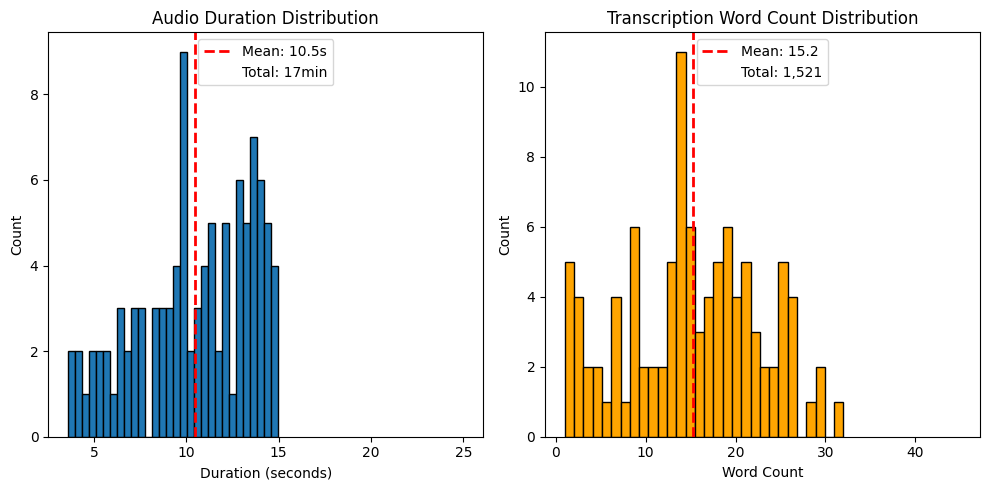

,text,audio_path,duration,char_count,word_count
id,,,,,
64,pulini professorim... bu 400 dollar pulni choʻ...,00000064.wav,6.608000,71,10
173,yashirin iqtisodiyot bilan kurashish yangi pog...,00000173.wav,6.298687,70,8
245,va hokazo deb qanaqa qilibdir o'tkazishgan-da ...,00000245.wav,6.593500,82,11
250,zot tayinlanishi bilan tugagan.,00000250.wav,3.792000,31,4
356,"birinchi kursini tugatib, akademicheskiy year ...",00000356.wav,8.869375,109,14
...,...,...,...,...,...
19824,kelajak qurish uchun bir kafolat bo'lmaydi. Al...,00019824.wav,13.861375,179,23
19957,yarim marafonda sal ko'proq shaxsiy rekordim. ...,00019957.wav,13.381375,203,25
20191,"beradi, ularning huquqlari poymol qilinmaydi d...",00020191.wav,11.112187,61,7


In [23]:
short_random_samples = (
    df[df["duration"] <= 15].sample(100, random_state=137).sort_index()
)
short_random_samples.to_csv(os.path.join(DATASET_DIR, "short_random_samples.csv"))

plot_distribution_graphs(short_random_samples)

short_random_samples

### Extract audios from parquet files to manually check the quality of the overall dataset 

In [6]:
# Extract audios from parquet files
sample_ids = set(short_random_samples.index.tolist())
print(f"Need to extract {len(sample_ids)} audio files")

# Create directory for extracted audio
audio_output_dir = os.path.join(DATASET_DIR, "random_sample_audio")
os.makedirs(audio_output_dir, exist_ok=True)

parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

found_count = 0
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    if found_count >= len(sample_ids):
        break

    df_partial = pd.read_parquet(parquet_file_path)
    df_partial["id"] = df_partial["id"].astype(int)
    df_partial.set_index("id", inplace=True)

    # Filter to only rows we need
    matching_rows = df_partial[df_partial.index.isin(sample_ids)]

    if len(matching_rows) < 1:
        del df_partial
        continue

    for idx, row in matching_rows.iterrows():
        audio_bytes = row["audio"]["bytes"]

        output_filename = row["audio"]["path"]
        output_path = os.path.join(audio_output_dir, output_filename)

        with open(output_path, "wb") as f:
            f.write(audio_bytes)

        found_count += 1

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

print(f"\nExtracted {found_count} audio files to {audio_output_dir}")

Need to extract 100 audio files
Found 34 parquet files. Started processing...



Processing files: 100%|██████████| 34/34 [00:34<00:00,  1.00s/it]


Extracted 100 audio files to ./datasets/news_youtube_uzbek_speech_dataset/data/random_sample_audio


### With the help of LLM, I created simple custom HTML tool to quickly check the quality of ASR datasets.

Screenshot of the tool:

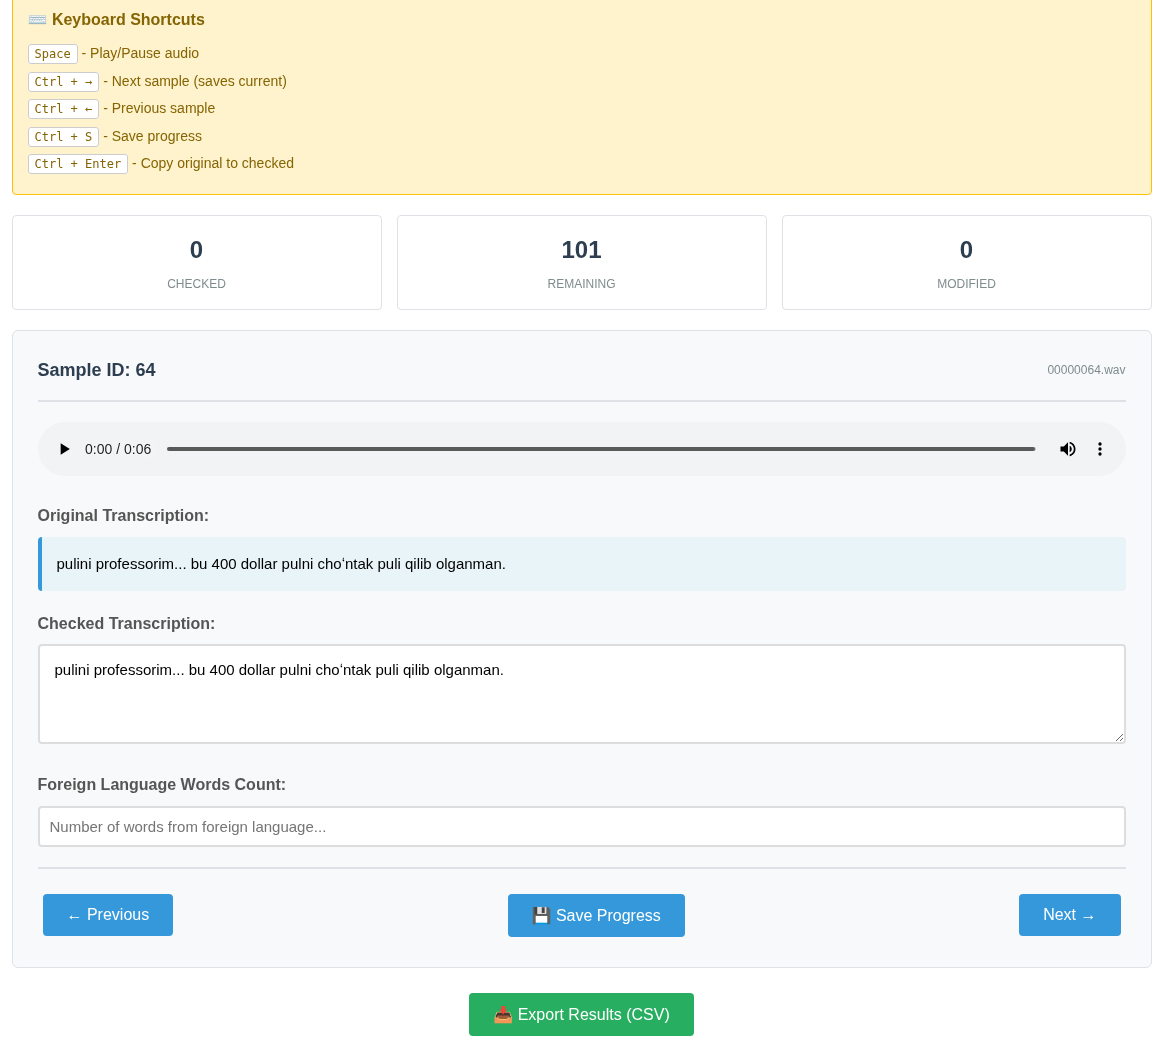

### Compute WER and CER values against manually checked transcripts

In [ ]:
import jiwer

df_checked = pd.read_csv(
    os.path.join(DATASET_DIR, "asr_checked_results.csv"), index_col="id"
)
df_checked["foreign_words_count"] = df_checked["foreign_words_count"].fillna(0)

# Compute WER and CER for each sample
wer_scores = []
cer_scores = []

for idx, row in df_checked.iterrows():
    reference = row["text_checked"]
    hypothesis = row["text"]

    # Compute WER
    wer = jiwer.wer(reference, hypothesis)
    wer_scores.append(wer)

    # Compute CER
    cer = jiwer.cer(reference, hypothesis)
    cer_scores.append(cer)

# Add WER and CER columns to dataframe
df_checked["wer"] = wer_scores
df_checked["cer"] = cer_scores

# Compute averages
avg_wer = sum(wer_scores) / len(wer_scores) if wer_scores else 0
avg_cer = sum(cer_scores) / len(cer_scores) if cer_scores else 0
avg_foreign_words = df_checked["foreign_words_count"].mean()

print("=" * 60)
print("DATASET QUALITY METRICS")
print("=" * 60)
print(f"Number of samples evaluated: {len(df_checked)}")
print(f"\nAverage WER (Word Error Rate): {avg_wer:.2%}")
print(f"Average CER (Character Error Rate): {avg_cer:.2%}")
print(f"Average Foreign Words Count: {avg_foreign_words:.2f}")
print(f"Total Foreign Words: {int(df_checked['foreign_words_count'].sum())}")
print("=" * 60)

DATASET QUALITY METRICS
Number of samples evaluated: 100

Average WER (Word Error Rate): 6.83%
Average CER (Character Error Rate): 1.59%
Average Foreign Words Count: 0.27
Total Foreign Words: 27
